In [12]:
import torch
import torch.optim as optim
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
import copy
import time
import os
import sys
import joblib # For loading label encoder
from tqdm.notebook import tqdm # Use notebook-friendly tqdm

In [13]:
PROJECT_ROOT = os.path.abspath('.') # Or specify your project root
PATH_TO_SRC = os.path.join(PROJECT_ROOT, 'src')
if PATH_TO_SRC not in sys.path:
    sys.path.append(PATH_TO_SRC)
    print(f"Added '{PATH_TO_SRC}' to sys.path")

project_root = os.path.abspath(os.path.join(os.getcwd(), '..'))
if project_root not in sys.path:
    sys.path.append(project_root)

In [14]:
try:
    import src.config as cfg
    from src.dataset import get_data_loaders, BirdSoundDataset
    from src.resnet18 import get_bird_model
    from src.utils import train_one_epoch
    print("Successfully imported project modules.")
except ImportError as e:
    print(f"ERROR importing project modules: {e}")
    print("Please ensure your 'src' directory and .py files are correctly set up.")
    # Stop execution if imports fail
    raise SystemExit("Module import failed. Please check setup.")

Successfully imported project modules.


In [15]:
print(f"--- Current Configuration ---")
print(f"Device: {cfg.DEVICE}")
print(f"Target Label Column: {cfg.TARGET_LABEL_COLUMN}")
print(f"Batch Size: {cfg.BATCH_SIZE}")
print(f"Number of Epochs: {cfg.NUM_EPOCHS}")
print(f"Learning Rate: {cfg.LEARNING_RATE}")
print(f"Audio Sample Rate: {cfg.SAMPLE_RATE}")
print(f"Spectrogram Mel Bins: {cfg.N_MELS}")
print(f"Spectrogram Fixed Frames: {cfg.FIXED_SPEC_FRAMES}")
print(f"Train CSV Path: {cfg.TRAIN_CSV_PATH}")
print(f"Train Audio Dir: {cfg.TRAIN_AUDIO_DIR}")
print(f"Best Model Save Path: {cfg.BEST_MODEL_SAVE_PATH}")
print(f"Label Encoder Save Path: {cfg.LABEL_ENCODER_SAVE_PATH}")

--- Current Configuration ---
Device: cuda
Target Label Column: common_name
Batch Size: 16
Number of Epochs: 5
Learning Rate: 0.001
Audio Sample Rate: 16000
Spectrogram Mel Bins: 128
Spectrogram Fixed Frames: 157
Train CSV Path: d:\BirdCLEF_2025\data\metadata\train.csv
Train Audio Dir: d:\BirdCLEF_2025\data\train_audio
Best Model Save Path: d:\BirdCLEF_2025\models\simple_best_model.pth
Label Encoder Save Path: d:\BirdCLEF_2025\models\simple_label_encoder.joblib


In [16]:
try:
    print("Loading data...")
    train_loader, val_loader, label_encoder, num_classes = get_data_loaders()
    print(f"Data loaded successfully!")
    print(f"Number of classes determined: {num_classes}")
    print(f"Train DataLoader: {len(train_loader)} batches.")
    print(f"Validation DataLoader: {len(val_loader)} batches.")
    
    # Store num_classes in config for consistency if needed elsewhere, though passing it is safer
    # cfg.NUM_CLASSES = num_classes # Optional: update config if it was a placeholder
    
except Exception as e:
    print(f"ERROR during data loading: {e}")
    import traceback
    traceback.print_exc()
    # Stop execution if data loading fails
    raise SystemExit("Data loading failed.")

Loading data...
Loading data from CSV: d:\BirdCLEF_2025\data\metadata\train.csv
Found 28564 existing audio files out of 28564 listed in CSV.
Number of unique classes found ('common_name'): 206
LabelEncoder saved to d:\BirdCLEF_2025\models\simple_label_encoder.joblib
Train DataLoader: 1429 batches. Val DataLoader: 358 batches.
Data loaded successfully!
Number of classes determined: 206
Train DataLoader: 1429 batches.
Validation DataLoader: 358 batches.


Fetching one batch from train_loader...
Inputs batch shape: torch.Size([16, 3, 128, 157])
Labels batch shape: torch.Size([16])
Inputs dtype: torch.float32
Labels dtype: torch.int64
Min label in batch: 50, Max label in batch: 194
A few labels: [50, 78, 188, 163, 50]


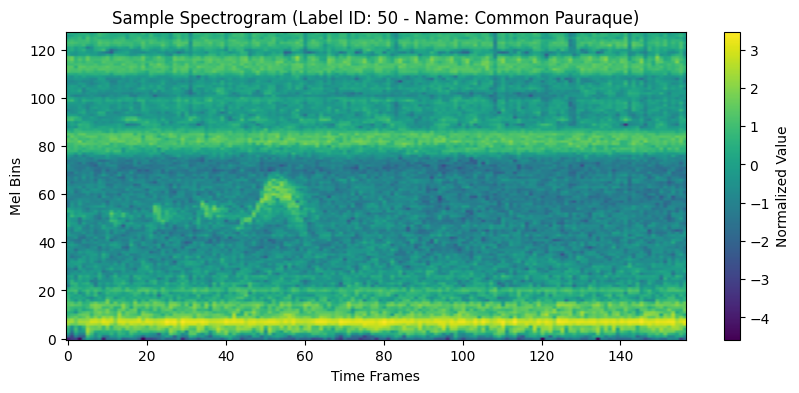

In [17]:
if 'train_loader' in locals() and train_loader is not None:
    try:
        print("Fetching one batch from train_loader...")
        inputs, labels = next(iter(train_loader))

        print(f"Inputs batch shape: {inputs.shape}") # Expected: (BATCH_SIZE, 3, N_MELS, FIXED_SPEC_FRAMES)
        print(f"Labels batch shape: {labels.shape}") # Expected: (BATCH_SIZE,)
        print(f"Inputs dtype: {inputs.dtype}")
        print(f"Labels dtype: {labels.dtype}")
        print(f"Min label in batch: {labels.min().item()}, Max label in batch: {labels.max().item()}")
        print(f"A few labels: {labels[:5].tolist()}")

        # Visualize a spectrogram
        if inputs.numel() > 0: # Check if inputs tensor is not empty
            sample_idx = 0
            # Spectrogram is (3, N_MELS, SPEC_FRAMES), take the first channel for visualization
            spectrogram_to_show = inputs[sample_idx][0].cpu().numpy() # .cpu() 
            label_id = labels[sample_idx].item()
            
            plt.figure(figsize=(10, 4))
            plt.imshow(spectrogram_to_show, aspect='auto', origin='lower', cmap='viridis')
            plt.colorbar(label='Normalized Value')
            plt.title(f"Sample Spectrogram (Label ID: {label_id} - Name: {label_encoder.classes_[label_id]})")
            plt.xlabel("Time Frames")
            plt.ylabel("Mel Bins")
            plt.show()
        else:
            print("Inputs tensor is empty, cannot visualize spectrogram.")
            
    except StopIteration:
        print("Train loader is empty or exhausted.")
    except Exception as e:
        print(f"Error inspecting batch: {e}")
        import traceback
        traceback.print_exc()
else:
    print("Train_loader not available for inspection.")

In [18]:
if 'num_classes' not in locals() or num_classes is None:
    print("Error: num_classes not defined. Please ensure data loading step (3) was successful.")
    # Stop execution
    raise SystemExit("num_classes missing.")

print(f"Initializing model for {num_classes} classes...")
model = get_bird_model(num_classes=num_classes, pretrained=True)
model = model.to(cfg.DEVICE)

# Loss Function
criterion = nn.CrossEntropyLoss()

# Optimizer
optimizer = optim.Adam(model.parameters(), lr=cfg.LEARNING_RATE)

print("Model, Criterion, and Optimizer initialized.")
# You can print the model summary if you like:
# print(model)

Initializing model for 206 classes...
Loading ResNet18 with pre-trained ImageNet weights.
ResNet18 final layer replaced: 512 in-features, 206 out-features.
Model, Criterion, and Optimizer initialized.


In [19]:
if os.path.exists(cfg.BEST_MODEL_SAVE_PATH):
    print(f"Loading saved model weights from: {cfg.BEST_MODEL_SAVE_PATH}")
    try:
        # Load the state dict
        state_dict = torch.load(cfg.BEST_MODEL_SAVE_PATH, map_location=cfg.DEVICE)
        
        # Ensure the loaded state_dict is compatible with the current model architecture
        # (especially the number of classes in the final layer)
        model_fc_out_features = model.fc.out_features
        
        # Check if the state_dict is directly from model.state_dict() or from a checkpoint dict
        # Our current simple save saves model.state_dict() directly.
        # If it were a checkpoint dict, it might be state_dict['model_state_dict']
        
        # Basic check for the final layer's compatibility
        loaded_fc_out_features = None
        if 'fc.weight' in state_dict: # Common way to check output features of fc layer
            loaded_fc_out_features = state_dict['fc.weight'].shape[0]
        
        if loaded_fc_out_features is not None and loaded_fc_out_features != model_fc_out_features:
            print(f"WARNING: Mismatch in final layer output features!")
            print(f"  Current model expects: {model_fc_out_features} features (num_classes={num_classes}).")
            print(f"  Loaded model has: {loaded_fc_out_features} features.")
            print(f"  Ensure `num_classes` (from data loading) matches the saved model's architecture.")
            print(f"  If they don't match, loading weights might fail or lead to unexpected behavior.")
            # Decide how to handle: error out, or try to load anyway (might need strict=False)
            # For now, we'll attempt to load, but this is a critical warning.
        
        model.load_state_dict(state_dict)
        print("Successfully loaded model weights.")
        
        # Note: Optimizer state is not saved in BEST_MODEL_SAVE_PATH in this simple setup.
        # So, the optimizer will start fresh. For full checkpointing, save/load optimizer state too.

    except Exception as e:
        print(f"Error loading model weights: {e}")
        print("Training will start with the initialized model (potentially random or ImageNet weights if pretrained=True in cell 4).")
else:
    print(f"No saved model found at {cfg.BEST_MODEL_SAVE_PATH}. Training will start with the initialized model.")


# Loss Function
criterion = nn.CrossEntropyLoss()

# Optimizer
optimizer = optim.Adam(model.parameters(), lr=cfg.LEARNING_RATE)

print("Model, Criterion, and Optimizer initialized.")

Loading saved model weights from: d:\BirdCLEF_2025\models\simple_best_model.pth
Successfully loaded model weights.
Model, Criterion, and Optimizer initialized.


In [20]:
history_log = {'train_loss': [], 'train_acc': [], 'val_loss': [], 'val_acc': []}
best_val_acc = 0.0
best_model_state = None # To store the state_dict of the best model

print(f"\n--- Starting Training ---")
training_start_time = time.time()
EPOCH = 10
for epoch in range(EPOCH):
    epoch_start_time = time.time()
    print(f"\nEpoch {epoch+1}/{EPOCH}")
    print("-" * 20)

    # --- Training Phase ---
    train_loss, train_acc = train_one_epoch(
        model, train_loader, criterion, optimizer, cfg.DEVICE, phase_name="Train"
    )
    history_log['train_loss'].append(train_loss)
    history_log['train_acc'].append(train_acc)
    print(f"Epoch {epoch+1} Train: Loss={train_loss:.4f}, Acc={train_acc:.4f}")

    # --- Validation Phase ---
    val_loss, val_acc = train_one_epoch(
        model, val_loader, criterion, optimizer, cfg.DEVICE, phase_name="Validation"
    )
    history_log['val_loss'].append(val_loss)
    history_log['val_acc'].append(val_acc)
    print(f"Epoch {epoch+1} Validation: Loss={val_loss:.4f}, Acc={val_acc:.4f}")
    
    epoch_duration = time.time() - epoch_start_time
    print(f"Epoch {epoch+1} Duration: {epoch_duration:.2f} seconds")

    # Save the best model
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        best_model_state = copy.deepcopy(model.state_dict())
        try:
            torch.save(best_model_state, cfg.BEST_MODEL_SAVE_PATH)
            print(f"*** New best validation accuracy: {best_val_acc:.4f}. Model saved to {cfg.BEST_MODEL_SAVE_PATH} ***")
        except Exception as e:
            print(f"Error saving best model: {e}")
            
training_duration = time.time() - training_start_time
print(f"\n--- Training Finished ---")
print(f"Total Training Time: {training_duration // 60:.0f}m {training_duration % 60:.0f}s")
print(f"Best Validation Accuracy: {best_val_acc:.4f}")

# Load the best model weights back into the model object
if best_model_state:
    model.load_state_dict(best_model_state)
    print("Loaded best model weights into the model.")
else:
    print("No best model state was saved (e.g., if validation accuracy never improved or no validation samples).")




--- Starting Training ---

Epoch 1/10
--------------------


Epoch 1 Train: Loss=1.9946, Acc=0.5542


Epoch 1 Validation: Loss=1.7688, Acc=0.5971
Epoch 1 Duration: 1784.55 seconds
*** New best validation accuracy: 0.5971. Model saved to d:\BirdCLEF_2025\models\simple_best_model.pth ***

Epoch 2/10
--------------------


Epoch 2 Train: Loss=1.8450, Acc=0.5788


Epoch 2 Validation: Loss=1.7953, Acc=0.5943
Epoch 2 Duration: 1765.62 seconds

Epoch 3/10
--------------------


Epoch 3 Train: Loss=1.7133, Acc=0.6065


Epoch 3 Validation: Loss=1.7076, Acc=0.6315
Epoch 3 Duration: 2403.65 seconds
*** New best validation accuracy: 0.6315. Model saved to d:\BirdCLEF_2025\models\simple_best_model.pth ***

Epoch 4/10
--------------------


Epoch 4 Train: Loss=1.6081, Acc=0.6295


Epoch 4 Validation: Loss=1.6728, Acc=0.6275
Epoch 4 Duration: 1180.29 seconds

Epoch 5/10
--------------------


Epoch 5 Train: Loss=1.5286, Acc=0.6483


Epoch 5 Validation: Loss=1.5700, Acc=0.6625
Epoch 5 Duration: 1137.62 seconds
*** New best validation accuracy: 0.6625. Model saved to d:\BirdCLEF_2025\models\simple_best_model.pth ***

Epoch 6/10
--------------------


Epoch 6 Train: Loss=1.4269, Acc=0.6697


Epoch 6 Validation: Loss=1.5771, Acc=0.6587
Epoch 6 Duration: 1154.40 seconds

Epoch 7/10
--------------------


Epoch 7 Train: Loss=1.3733, Acc=0.6812


Epoch 7 Validation: Loss=1.6956, Acc=0.6391
Epoch 7 Duration: 1155.31 seconds

Epoch 8/10
--------------------


Epoch 8 Train: Loss=1.3102, Acc=0.6940


Epoch 8 Validation: Loss=1.6062, Acc=0.6615
Epoch 8 Duration: 1097.75 seconds

Epoch 9/10
--------------------


Epoch 9 Train: Loss=1.2288, Acc=0.7106


Epoch 9 Validation: Loss=1.6725, Acc=0.6588
Epoch 9 Duration: 1165.16 seconds

Epoch 10/10
--------------------


Epoch 10 Train: Loss=1.1823, Acc=0.7221


Epoch 10 Validation: Loss=1.5993, Acc=0.6702
Epoch 10 Duration: 1160.76 seconds
*** New best validation accuracy: 0.6702. Model saved to d:\BirdCLEF_2025\models\simple_best_model.pth ***

--- Training Finished ---
Total Training Time: 233m 26s
Best Validation Accuracy: 0.6702
Loaded best model weights into the model.


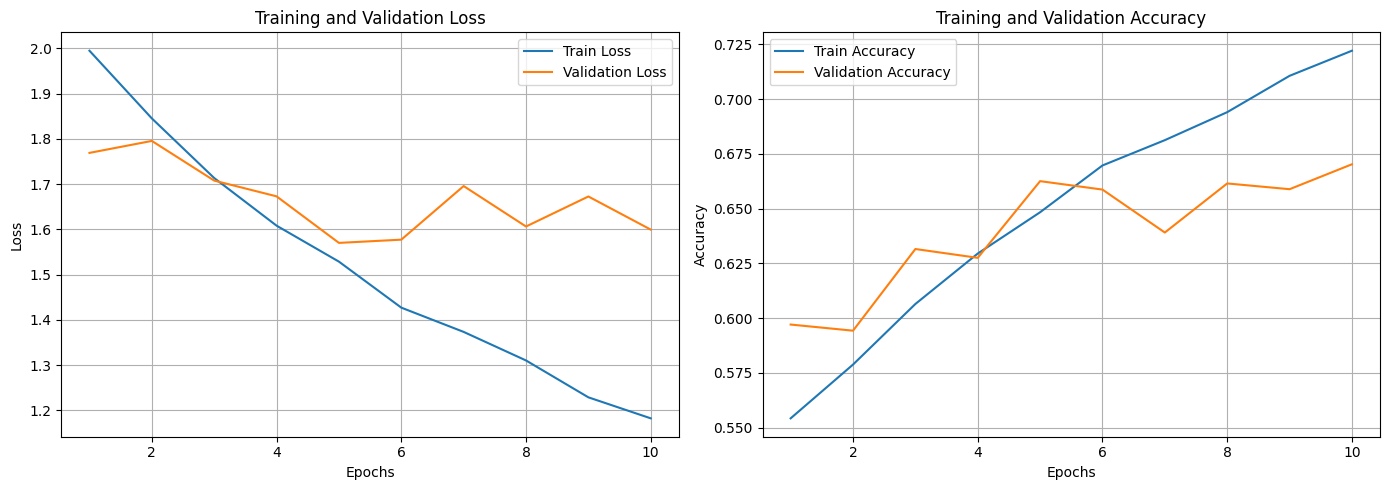

In [23]:
if history_log['train_loss']: # Check if training actually ran
    epochs_range = range(1, EPOCH + 1)

    plt.figure(figsize=(14, 5))

    plt.subplot(1, 2, 1)
    plt.plot(epochs_range, history_log['train_loss'], label='Train Loss')
    plt.plot(epochs_range, history_log['val_loss'], label='Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Training and Validation Loss')
    plt.legend()
    plt.grid(True)

    plt.subplot(1, 2, 2)
    plt.plot(epochs_range, history_log['train_acc'], label='Train Accuracy')
    plt.plot(epochs_range, history_log['val_acc'], label='Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.legend()
    plt.grid(True)

    plt.tight_layout()
    plt.show()
else:
    print("No training history to plot.")